# Calculation of edge orientation

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import math

img = cv.imread("fisherman.jpg")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img2 = cv.imread("empire.jpg")
img_gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

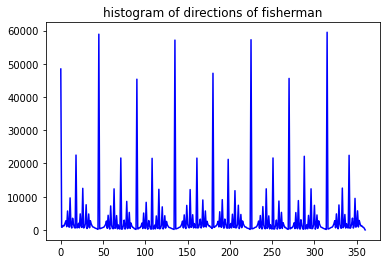

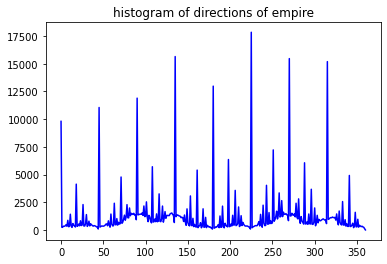

1

In [46]:
def histogram(img, title):
    height, width = img.shape
    ori_img_gray = np.zeros((height, width), np.float32)

    D_x = np.float32([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8 
    der_x = cv.filter2D(img, cv.CV_32F, D_x) 
    D_y = np.float32([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) / 8
    der_y = cv.filter2D(img, cv.CV_32F, D_y)

    for i in range(0, width):
        for j in range(0, height):
            if der_x[j,i]==0 and der_y[j,i]==0:
                ori_img_gray[j,i] = math.inf
            else: 
                ori_img_gray[j,i] = math.degrees(math.atan2(der_y[j,i], der_x[j,i]))+90
                if ori_img_gray[j,i]>=-90 and ori_img_gray[j,i]<0:
                    ori_img_gray[j,i]+=360

    hist = cv.calcHist([ori_img_gray],[0],None,[361],[0,361])
    plt.plot(hist, color='b')
    plt.title(title)
    plt.show()
    return 1


histogram(img_gray, "histogram of directions of fisherman"), 
histogram(img_gray2, "histogram of directions of empire")

In both images most edges have an angle of 0°. However, this phenomenon is much more extrem for the image "fisherman". Both images have some edges with an orientation between 250° and 360°. However, it is not not visible that edges have orientations in the interval [1,250] in both images.

# Applying morphology for document skew estimation

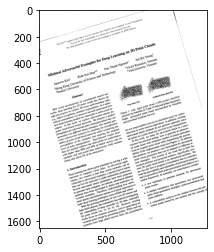

In [23]:
doc = cv.imread("doc.jpg", 0)
threshold = 200
ret, doc_bin = cv.threshold(doc, threshold, 255, cv.THRESH_BINARY)
cv.imwrite("doc_bin.png", doc_bin)
plt.imshow(doc_bin, "gray")

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_11100\3014390723.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  closing_se = np.ones((1,15), np.int)


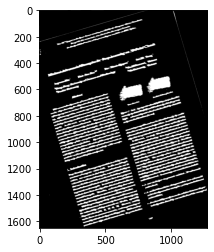

In [24]:
closing_se = np.ones((1,15), np.int)
doc_bin = 255 - doc_bin
closing = cv.morphologyEx(doc_bin, cv.MORPH_CLOSE, closing_se)
plt.imshow(closing, "gray")

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_11100\134027547.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  opening_se = np.ones((8,8), np.int)


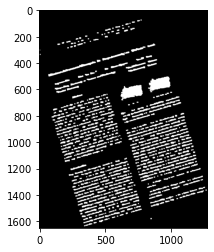

In [25]:
opening_se = np.ones((8,8), np.int)
opening = cv.morphologyEx(closing, cv.MORPH_OPEN, opening_se)
plt.imshow(opening, "gray")


In [26]:
num_labels, labels_im = cv.connectedComponents(opening)

def ExtractConnectedComponents(num_labels, labels_im):
    connected_components = [[] for i in range(0, num_labels)]
    height, width = labels_im.shape
    for i in range(0, height):
        for j in range(0, width):
            if labels_im[i,j]>=0:
                connected_components[labels_im[i,j]].append((j,i))
    return connected_components

connected_components = ExtractConnectedComponents(num_labels, labels_im)



In [43]:
import math
def FindOrientation(cc):
    mx, my, mxy, mxx, myy, mxy = 0,0,0,0,0,0

    for i in range(0, len(cc)):
        mx += cc[i][0] 
        my += cc[i][1]
    mx /= len(cc)
    my /= len(cc)

    for i in range(0, len(cc)):
        dx = cc[i][0] - mx
        dy = cc[i][1] - my
        mxx += (dx*dx)
        myy += (dy * dy) 
        mxy += (dx * dy) 
    mxx /= len(cc) 
    myy /= len(cc) 
    mxy /= len(cc)
    theta = - math.atan2(2 * mxy, mxx - myy) / 2 
    return theta

orientations = np.zeros(num_labels, np.float32) 
for i in range(0, num_labels):
    orientations[i] = FindOrientation(connected_components[i])


In [44]:
import statistics 
orientation = statistics.median(orientations)

13.455450466810317


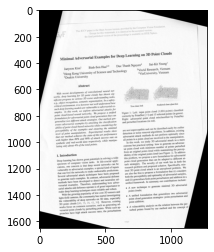

In [48]:
height, width = doc.shape
c_x = (width -1)/2.0
c_y = (height -1)/2.0
c = (c_x, c_y)

M = cv.getRotationMatrix2D(c, -orientation*180/math.pi, 1)
print(orientation*180/math.pi)
doc_deskewed = cv.warpAffine(doc, M, (width, height))
plt.imshow(doc_deskewed, "gray")